In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from tqdm import tqdm_notebook as progbar
from collections import deque, Counter
import numpy as np
import pandas as pd
from cycler import cycler
from scipy.stats import rankdata
import os

import loc_utils as lut
import vis_utils as vut
from standards import *

rx = RAWXix()
r = RAWix()

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f']

glabels = {0: 'F', 1: 'S'}
clabels = {0: 'i-', 1: 'i+'}

def gclabel(g, c):
    return '{}/{}'.format(glabels[g], clabels[c])

tlabels = {
        1: '1D',
        2: 'I1D',
        3: '2D',
        4: 'R'}

saveloc = '/Users/alexten/Projects/HFSP/img'

# Outliers

## 1.1. Task allocation variance

In [ ]:
path = 'pipeline_data/s3/joint_data.pkl'
title = ''
figname = 'task_allocation_variance_clean'
save_as = 'svg'

if 0:
    from s3_remove_outliers import measure_allocation_variance
    fig, ax = plt.subplots(1,1, num=figname, figsize=[8,6])
    
    data = lut.unpickle(path)['main']
    
    data = measure_allocation_variance(data)
    nbins = vut.fd_bins(data)+2
    
    vut.add_stds(ax, data, 10, False)
    sns.despine(top=True, right=True)

    sns.distplot(data, bins = nbins, 
                 rug=True, kde=False,
                 rug_kws={'alpha':0.7, 'height':0.02, 'color':'k', 'linewidth':1},
                 hist_kws={'normed': False, 'weights': np.zeros_like(data) + 1./data.size, 
                           'alpha':1, 'color':'darkgray'},
                 ax=ax)
    ax.set_xlim(0, 115)
    ax.axvline(np.mean(data), c='r', lw=1.5)

    vut.add_labels(
        ax=ax,
        title=title,
        x='Standard deviation (bins={})'.format(nbins),
        y='Relative frequency')
    
    if save_as:
        fig.subplots_adjust(top=.95)
        fig.savefig(saveloc+'/{}.{}'.format(figname, save_as), format=save_as, dpi=500)

## 1.2. Stickers vs non-stickers

In [ ]:
path = 'pipeline_data/s2/joint_data.pkl'
title = ''
figname = 'stickers_nonstickers'
save_as = 'svg'

if 0:
    from s3_remove_outliers import detect_by_allocation_variance
    
    def plot_play(ax, data, sids, title):
        clrix = np.linspace(0, 1, len(sids))
        rolling_max = 0
        for i, (cix, sid) in enumerate(zip(clrix, sids)):
            mask = lut.get_mask(data, {r.ix('sid'):sid, r.ix('stage'):1})
            free_trials = data[mask, r.ix('cat')]
            if free_trials.size > rolling_max:
                rolling_max = free_trials.size
            ax.plot(xs = np.array([i for i in range(1, free_trials.size + 1)]),
                    ys = free_trials,
                    zs = i, 
                    c=plt.cm.Dark2(cix), lw=1, alpha=.8)
        ax.azim = -35
        ax.elev = -130

        ax.set_xlabel('trial')
        ax.set_ylabel('task'); ax.set_yticks([1,2,3,4]), ax.set_yticklabels(['1D', 'I1D', '2D', 'R'])
        ax.set_zlabel('participants'); ax.set_zticks([]), ax.set_zticklabels([])
        ax.set_title(title)
        ax.set_xlim=(0, rolling_max)
        ax.set_ylim=(0,5)
    
    data = lut.unpickle(path)['main']
    sids = lut.get_unique(data, r.ix('sid'))
    
    cutoff_val = 100
    small_sample = 15
    stickers = detect_by_allocation_variance(data, crit=cutoff_val)
    nonstickers = sids[np.logical_not(np.isin(sids, stickers))]
    
    fig = plt.figure(num=figname, figsize=[8,8])
    
    dd = {
        'stickers all (N={})'.format(len(stickers)): stickers,
        'nonstickers all (N={})'.format(len(nonstickers)): nonstickers,
        'stickers sample (N={})'.format(small_sample): np.random.choice(stickers, small_sample, replace=False), 
        'nonstickers sample (N={})'.format(small_sample): np.random.choice(nonstickers, small_sample, replace=False)
    }
    
    for i, (k, v) in enumerate(dd.items()):
        ax = fig.add_subplot(2,2,i+1, projection='3d')
        plot_play(ax, data, v, k)
    
    if save_as:
        fig.subplots_adjust(top=.95)
        fig.savefig(saveloc+'/{}.{}'.format(figname, save_as), format=save_as, dpi=500)

## 2. Mean choice bias across tasks

In [ ]:
path = 'pipeline_data/s2/joint_data.pkl'
figname = 'average_choice_bias_across_tasks_raw'
title = ''
save_as = 'svg'

if 0:
    from s3_remove_outliers import measure_choice_bias
    fig, ax = plt.subplots(1,1, num=figname, figsize=[8,6])
    nbins = 50
    
    data = lut.unpickle(path)['main']
    data = measure_choice_bias(data, collapse_tasks=True)
    nbins = vut.fd_bins(data)

    vut.add_stds(ax, data, 10, False)
    sns.despine(top=True, right=True)

    sns.distplot(data, bins = nbins, 
                 rug=True, kde=False,
                 rug_kws={'alpha':0.7, 'height':0.02, 'color':'k', 'linewidth':1},
                 hist_kws={'normed': False, 'weights': np.zeros_like(data) + 1./data.size, 
                           'alpha':1, 'color':'darkgray'},
                 ax=ax)
    ax.set_xlim(.5, 1)
    ax.axvline(np.mean(data), c='r', lw=1.5)

    vut.add_labels(
        ax=ax,
        title=title,
        x='Choice bias (bins={})'.format(nbins),
        y='Relative frequency')
    
    if save_as:
        fig.subplots_adjust(top=.95)
        fig.savefig(saveloc+'/{}.{}'.format(figname, save_as), format=save_as, dpi=500)

## 3. Training and learning performance
### 3.1. Prepare data

In [ ]:
path = 'pipeline_data/s3/joint_data.pkl'

train_window_0 = 5
train_window_1 = 5
test_window = 10

save_as = 'pipeline_data/learning_analysis/learning_data-{}-{}-clean.pkl'.format(train_window_1, test_window)

if 0:
    from s3_remove_outliers import remove_by_sid
    
    mdata = lut.unpickle(path)['main']
    lut.report_subject_counts(mdata)

    tasks = lut.get_unique(mdata, r.ix('cat'))[0:-1]
    
    sids_col = []
    groups_col = []
    conds_col = []
    testsize_col = []
    teststart_col = []
    task_col = []
    train_pc_0 = []
    train_pc_1 = []
    test_pc = []
    
    # Locally, check for outliers (those who didn't play at least `test_widnow` times on free play)
    outliers = []
    g0 = lut.get_mask(mdata, {r.ix('group'): 0})
    sids_g0 = lut.get_unique(mdata[g0,:], r.ix('sid'))
    for sid in progbar(sids_g0, desc='1. Outliers:'):
        for tsk in tasks:
            mask = lut.get_mask(mdata, {r.ix('sid'): sid, r.ix('stage'): 1, r.ix('cat'): tsk})
            if np.sum(mask) < test_window:
                outliers.append(sid)

    mdata = remove_by_sid(mdata, list(set(outliers)), assign_new_ids=False)
    lut.report_subject_counts(mdata)
    
    sids = lut.get_unique(mdata, r.ix('sid'))
    for sid in progbar(sids, desc='2. Data'):
        subject_mask = lut.get_mask(mdata, {r.ix('sid'):sid})
        grp = mdata[subject_mask, r.ix('group')][0]
        cnd = mdata[subject_mask, r.ix('cond')][0]
        for tsk in tasks:
            # Compute test data
            mask = lut.get_mask(mdata, {r.ix('sid'): sid, r.ix('stage'): 1 + grp, r.ix('cat'): tsk})
            test = mdata[mask, r.ix('cor')]
            test_pc.append(np.mean(test[-test_window:]))
            testsize_col.append(test.size)
            teststart_col.append(mdata[mask, r.ix('trial')][-test_window])
            
            # Compute train data
            mask = lut.get_mask(mdata, {r.ix('sid'): sid, r.ix('stage'): 0, r.ix('cat'): tsk})
            train = mdata[mask, r.ix('cor')]
            train_pc_0.append(np.mean(train[:train_window_0]))
            train_pc_1.append(np.mean(train[-train_window_1:]))

            # Record epi data
            groups_col.append(grp)
            conds_col.append(cnd)
            sids_col.append(sid)
            task_col.append(tsk)
            
    
    data = np.stack(
        map(np.array, [groups_col, sids_col, conds_col, task_col, 
                       teststart_col, testsize_col, 
                       train_pc_0, train_pc_1, test_pc]
           )).T
    
    if save_as:
        lut.dopickle(save_as, data)

### 3.2. Visualize

In [ ]:
path = 'pipeline_data/learning_analysis/learning_data-10-10-clean.pkl'
figname = path.split('/')[-1].split('.')[0]
save_as = 'svg'
np.set_printoptions(threshold=20000, precision=2, suppress=True)
if 0:
    cols = ['group', 'sid', 'cond', 'task', 'test_start', 'test_size', 'train_pc_0', 'train_pc_1', 'test_pc',
            'delta_0', 'delta_1']
    ix = cols.index
    
    data = lut.unpickle(path)
    sids = lut.get_unique(data, ix('sid'))
    groups = lut.get_unique(data, ix('group'))
    tasks = lut.get_unique(data, ix('task'))
    
    data = np.concatenate(
        [
            data, 
            data[:,ix('train_pc_1')].reshape(-1,1) - data[:,ix('train_pc_0')].reshape(-1,1), 
            data[:,ix('test_pc')].reshape(-1,1) - data[:,ix('train_pc_1')].reshape(-1,1)
        ],
        axis = 1)
    
    print('{} subjects with negative delta PC'.format(np.sum(data[:, ix('delta_1')]<0)))
    
    data = data.reshape([-1, tasks.size, len(cols)])
    means = np.zeros([sids.size, 1, len(cols)])
    for i, sub in enumerate(data):
        means[i,:,:] = np.concatenate([sub[0,:ix('task')],[4],np.mean(sub[:,ix('test_start'):], axis=0)])

    data = np.concatenate([data, means], axis=1).reshape([-1, len(cols)])

    fig = plt.figure(num=figname, figsize=(9,6))
    spix = 1
    
    subtitles = {
        1: '1D',
        2: 'I1D',
        3: '2D',
        4: 'Mean'}
    
    xdata = 'train_pc_1' # <=======================
    ydata = 'delta_1'    # <=======================
    alpha = .1
    dotsize = 10
    
    xlims = (-.2, 1.2)
    ylims = (-1.2, 1.2)
    
    fitline = 0
    
    for grp in groups:
        for tsk in [1,2,3,4]:
            mask = lut.get_mask(data, {ix('group'): grp, ix('task'): tsk})
            x = data[mask, ix(xdata)]
            y = data[mask, ix(ydata)]
            
            ax = fig.add_subplot(2,4,spix, aspect=.5)
            ax.scatter(x=x, y=y, alpha=alpha, s=dotsize, c='k')
            
            ax.axhline(0, ls='dotted', c='gray', lw=.8)
            ax.axvline(.5, ls='dotted', c='gray', lw=.8)
            if fitline:
                ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), c='red', alpha=.5, lw=.8)
            ax.set_xlim(xlims)
            ax.set_ylim(ylims)
            
            ax.set_xlabel('PC' if '1' in xdata else xdata.replace('_', ' '))
            if spix <= 4: ax.set_title(subtitles[spix])
            if spix == 1 or spix == 5: 
                ax.set_ylabel('dPC' if '1' in ydata else ydata.replace('_', ' '))
            else:
                ax.yaxis.set_ticks([])
                ax.yaxis.set_ticklabels([])
            if spix == 4 or spix == 8: 
                ax.yaxis.set_label_position('right')
                ax.set_ylabel('Free' if spix == 4 else 'Strategic')
            spix += 1
    
    fig.subplots_adjust(hspace=.01, wspace=.05, top=.95)
    fig.tight_layout()
    if save_as:
        s = saveloc+'/{}.{}'.format(figname,save_as)
        fig.savefig(s, format=save_as, dpi=500)
        os.sytem('scour -i {} -o {}'.format(s, s.replace('img', 'img_compressed')))
        print('scour -i {} -o {}'.format(s, s.replace('img', 'img_compressed')))

## 4. Performance and Learnability ratings
### 4.1. Prepare data

In [ ]:
path = 'pipeline_data/s3/joint_data.pkl'
save_as = 'pipeline_data/pc_and_lrn/filtered.pkl'

if 0:
    data = lut.unpickle(path)
    
    mdata = data['main']
    xdata = data['extra']
    
    train_trials = lut.get_mask(mdata, {r.ix('trial'): 60}, '<=')
    mdata = mdata[train_trials, :]

    tasks = lut.get_unique(mdata, r.ix('cat'))
    groups = lut.get_unique(mdata, r.ix('group'))
    conds = lut.get_unique(mdata, r.ix('cond'))
    monsters = lut.get_unique(mdata, r.ix('fam')).tolist()
    
    _sid, _group, _cond, _task, _pc, _lrn = [], [], [], [], [], []
    
    for row in progbar(xdata, desc='extracting data'):
        sid = row[rx.ix('sid')]
        grp = row[rx.ix('group')]
        cnd = row[rx.ix('cond')]
        for tsk in tasks:
            deque(map(lambda x,y: x.append(y), [_sid, _group, _cond, _task], [sid, grp, cnd, tsk]))
            mask = lut.get_mask(mdata, conds={r.ix('sid'): sid, r.ix('group'): grp,
                                              r.ix('cond'): cnd,r.ix('cat'): tsk})
            mi = monsters.index(mdata[mask, r.ix('fam')][0])
            _pc.append(np.mean(mdata[mask, r.ix('cor')]))
            _lrn.append(row[rx.ix('q6m1') + mi * 7])
    
    data = np.stack(map(np.array, [_group, _sid, _cond, _task, _pc, _lrn])).T
    
    if save_as: lut.dopickle(save_as, data)

### 4.2. Visualize

<IPython.core.display.Javascript object>


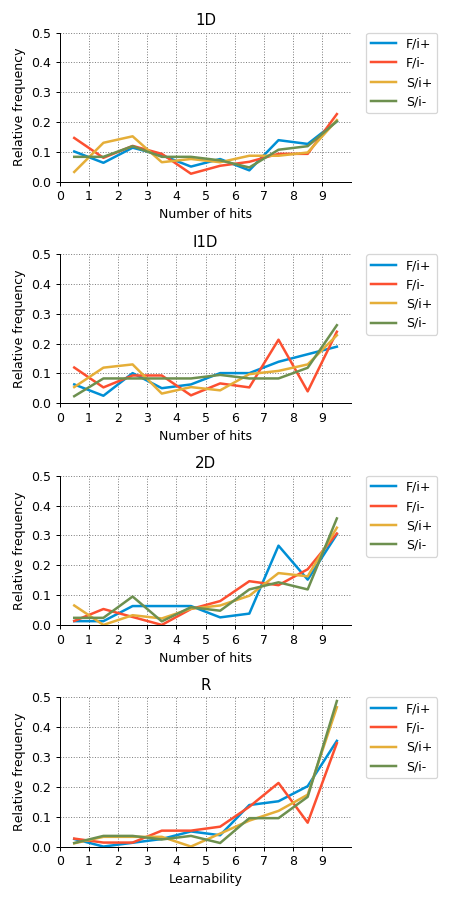

In [11]:
path = 'pipeline_data/pc_and_lrn/filtered.pkl'

X = 'lrn'
bins = np.arange(1,12) if X == 'lrn' else np.arange(0, 1.01 + 1/10, 1/10)

xlim = [1, 11] if X == 'lrn' else [0, 1.1]
ylim = [0, .5] if X == 'lrn' else [0, .5]
xlabel = 'Learnability' if X == 'lrn' else 'Percent correct'
legend = 1 if X == 'lrn' else 1
suptitle = 'Relative frequencies of {} for each task \nsplit by group ans condition'.format(X.upper())

figname = '/{}_clean'.format(X)
save_as = 'svg'

if 1:
    locix = ['group', 'sid', 'cond', 'task', 'pc', 'lrn'].index

    data = lut.unpickle(path)
    tasks, groups, conds = lut.get_unique(data, locix('task'), locix('group'), locix('cond'))
    
    plt.rc('axes', prop_cycle=cycler('color', ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']))
    plt.rc('lines', linewidth=2)

    fig = plt.figure(num='performance during training', figsize=[5,10])
    fig.subplots_adjust(right=.7)
    glabels = ['F' ,  'S']
    clabels = ['i-', 'i+']
    tlabels = ['1D', 'I1D', '2D', 'R']

    spix = 1
    for tsk in tasks:
        ax = fig.add_subplot(4,1,spix)
        ax.set_xlim(xlim[0], xlim[1])
        ax.set_ylim(ylim[0], ylim[1])
        for grp in groups:
            for cnd in reversed(conds):

                mask = lut.get_mask(data, {locix('group'): grp, locix('cond'): cnd, locix('task'): tsk})
                vut.line_histogram(ax, data[mask, locix(X)], bins = bins, 
                                   label='{}/{}'.format(glabels[grp], clabels[cnd]), precision=8, lw=2)
                
                if legend: ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                ax.set_title('{}'.format(tlabels[tsk-1]))
                ax.set_ylabel('Relative frequency')
                if 1: # <------------------------------------------------ TURN ON/OFF TICKER ROTATION HERE
                    ax.set_xticklabels([i for i in range(16)])
                    ax.set_xlabel('Number of hits')
                    # ax.set_xticklabels(np.around(bins,2), rotation=90)
                    # ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))

                if spix == 4: ax.set_xlabel(xlabel)
        spix += 1
    fig.subplots_adjust(right=.75, hspace=.3, top=.95 if save_as else .9)
    fig.tight_layout()
    # fig.suptitle(suptitle  if not save_as else '')
    
    if save_as:
        s = saveloc+'{}.{}'.format(figname, save_as)
        fig.savefig(s, format=save_as, dpi=500)
        os.system('scour -i {} -o {}'.format(s, s.replace('img', 'img_compressed')))

## 5. Task switching as a function of recent performance
### 5.1. Prepare data

In [ ]:
path = 'pipeline_data/s3/joint_data.pkl'
pc_window = 5

save_as = 'pipeline_data/task_switching/task_switching_{}_clean.pkl'.format(pc_window)

if 1:
    mdata = lut.unpickle(path)['main']
    freeplay = lut.get_mask(mdata, {r.ix('stage'): 1})
    mdata = mdata[freeplay, :]
    mdata[:, r.ix('trial')] -= 60
    mdata[:-1, r.ix('switch')] = mdata[:, r.ix('switch')][1:]
    mdata[-1, r.ix('switch')] = 0
    
    sids = lut.get_unique(mdata, r.ix('sid'))
    tasks = lut.get_unique(mdata, r.ix('cat'))
    groups = lut.get_unique(mdata, r.ix('group'))
    conds = lut.get_unique(mdata, r.ix('cond'))
    
    indices = np.arange(1, 300)
    data = []
    for grp in groups:
        
        task_count = dict(zip(tasks, [[] for task in tasks]))  # dict to keep track of total number of trials each subject played on each task
        task_outcome = dict(zip(tasks, [[] for task in tasks]))
        task_pc = dict(zip(tasks, [[] for task in tasks]))
        task_switch = dict(zip(tasks, [[] for task in tasks]))
        
        for tsk in tasks:
            tmask = lut.get_mask(mdata, {r.ix('cat'): tsk, r.ix('group'): grp})
            tdata = mdata[tmask, :] # get all data for current task

            task_subjects, nbt_subjects = lut.get_unique(tdata, r.ix('sid'), True)

            for i, sid in enumerate(task_subjects):
                smask = lut.get_mask(tdata, {r.ix('sid'): sid}) # get all data for current task and subject
                task_count[tsk].append(np.sum(smask))
                if np.any(smask):
                    task_outcome[tsk].append(tdata[smask, r.ix('cor')])
                    task_pc[tsk].append(lut.retro_pc(task_outcome[tsk][-1], pc_window))
                    task_switch[tsk].append(tdata[smask, r.ix('switch')])
        
        data.append({
            'count': task_count,
            'outcomes': task_outcome,
            'pc': task_pc,
            'switch': task_switch,
            'tasks': tasks})

    if save_as:
        lut.dopickle(save_as, data)

### 5.2. Visualize
#### 5.2.1. Task switching and recent performance

In [ ]:
import matplotlib as mpl
path = 'pipeline_data/task_switching/task_switching_5_clean.pkl'
rows = 10
cols = 2
alpha = 1
unsolvable_task = 4
fix_y = 0

figname = 'switching and performance'
save_as = 'svg'

def clip_vector(l, clip_val):
    return np.array([li[:cutoff] for li in l if li.size >= clip_val])


def plot_switch(ax, x, y, c, t, alpha=1, fixed_y=True):
    ax.grid()
    ax.scatter(x, y, s=15, alpha=alpha, c=c)
    # ax.plot(x, y, alpha=alpha, c=c)
    ax.set_xlim(0, x.size + x.size * .05)
    if fixed_y: ax.set_ylim(-.03,.13)
    ax.set_ylabel('Pr(switch)')
    ax.set_title(t)
    ax.tick_params(labelbottom='off', bottom=1, direction='out')
    vut.despine(ax, ['right', 'bottom'])
    
def plot_pc(ax, x, y, c, alpha=1, fixed_y=True):
    ax.grid()
    ax.plot(x, y, c=c, lw=2)
    ax.set_xlim(0, x.size + x.size * .05)
    if fixed_y: ax.set_ylim(0.4,1.0)
    ax.set_xlabel('trials on task')
    ax.xaxis.set_label_coords(.95, -.05)
    ax.set_ylabel('PC')
    ax.tick_params(labelbottom='off', labeltop='on', top=1, bottom=0, direction='out')
    vut.despine(ax, ['top', 'right'])


if 1:
    data = lut.unpickle(path)
    
    fig = plt.figure(num=figname.split('/')[-1].replace('_', ' '), figsize=[10,13])
    gs = mpl.gridspec.GridSpec(rows, cols)
    colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f']
    task_labels = ['1D', 'I1D', '2D', 'R']
    
    for gi, gdata in enumerate(data):
        pc = gdata['pc']
        switch = gdata['switch']
        tasks = gdata['tasks']
        min_trials = 10e4
        for ti, tsk in enumerate(tasks):
            
            # Sort subjets by the number of trials played on task
            pc[tsk].sort(key=lambda x: x.size)
            switch[tsk].sort(key=lambda x: x.size)

            # Compute how many trials were played by at least half of subjects
            half_pc = pc[tsk][np.ceil(len(pc[tsk])/2).astype(int)].size
            half_switch = switch[tsk][np.ceil(len(switch[tsk])/2).astype(int)].size

            # Filter select only those subjects who played at least the number of trials 
            # that at least half of subjects played
            pc[tsk] = np.stack([x[:half_pc] for x in pc[tsk] if x.size >= half_pc])
            switch[tsk] = np.stack([x[:half_switch] for x in switch[tsk] if x.size >= half_switch])

            # Compute data for plotting
            mean_pc = np.mean(pc[tsk], axis=0)
            p_switch = np.mean(switch[tsk], axis=0)
            trials = np.arange(mean_pc.size) + 1
            min_trials = min(min_trials, trials.size) if tsk != unsolvable_task else min_trials

            # Plot data
            ax1 = fig.add_subplot(gs[ti*2, gi])
            plot_switch(ax1, trials, p_switch, colors[ti], t=task_labels[ti], alpha=alpha, fixed_y=fix_y)

            ax2 = fig.add_subplot(gs[ti*2+1, gi])
            plot_pc(ax2, trials, mean_pc, colors[ti], alpha=alpha, fixed_y=fix_y)
        
        switch.pop(unsolvable_task)
        switch_pooled_mean = np.mean(np.concatenate([a[:,:min_trials] for a in switch.values()], axis=0), axis=0)
        trials = np.arange(min_trials) + 1
        
        ax1 = fig.add_subplot(gs[8, gi])
        plot_switch(ax1, trials, switch_pooled_mean, 'black', t='Mean over learnable tasks', alpha=alpha, fixed_y=fix_y)

        pc.pop(unsolvable_task)
        pc_pooled_mean = np.mean(np.concatenate([arr[:,:min_trials] for arr in pc.values()], axis=0), axis=0)
        ax2 = fig.add_subplot(gs[9, gi])
        plot_pc(ax2, trials, pc_pooled_mean, 'black', alpha=alpha, fixed_y=fix_y)


    if not save_as: plt.suptitle('Switching as a function of recent performance\n(columns: left = F, right = S)')
    
    if save_as:
        fig.subplots_adjust(hspace=0.45, top=.95, bottom=.05)
        fig.savefig(saveloc+'/{}.{}'.format(figname, save_as), format=save_as, dpi=500)

#### 5.2.2. Alternative visualization of task switching and recent performance

In [ ]:
path = 'pipeline_data/task_switching/task_switching_5_clean.pkl'
rows = 5
cols = 2
alpha = .7
ms = 'o'
unsolvable_task = 4
fix_x = True
fix_y = True
lin_fit = False

figname = 'switching and performance 2'.replace(' ', '_')
save_as = 'svg'

def clip_vector(l, clip_val):
    return np.array([li[:cutoff] for li in l if li.size >= clip_val])


def plot_pcVswitch(ax, x, y, title, color, alpha, marker, fixed_x=True, fixed_y=True):
    if fixed_x: 
        ax.set_xlim(.35, 1.05)
    if fixed_y: 
        ax.set_ylim(-0.02, .09)
        
    ax.set_title(title)
    ax.set_xlabel('PC')
    ax.xaxis.set_label_coords(1.1, 0.05)
    ax.set_ylabel('Pr(switch)')
    ax.grid(ls='--', alpha=.5)
    if lin_fit:
        results = sm.OLS(y, sm.add_constant(x)).fit()
        edges = np.array(ax.get_xlim())
        ax.plot(edges, edges*results.params[1] + results.params[0], c='k', alpha=.5)
    ax.scatter(x=x, y=y, c=color, alpha=alpha, marker=marker, s=15)
    vut.despine(ax, ['right', 'top'])
    
    
if 1:
    import statsmodels.api as sm
    data = lut.unpickle(path)
    fig = plt.figure(num=figname.split('/')[-1].replace('_', ' '), figsize=[7,13])
    gs = mpl.gridspec.GridSpec(rows, cols)
    colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f']
    task_labels = ['1D', 'I1D', '2D', 'R']
    
    for gi, gdata in enumerate(data):
        pc = gdata['pc']
        switch = gdata['switch']
        tasks = gdata['tasks']
        min_trials = 10e5
        for ti, tsk in enumerate(tasks):
            
            # Sort subjets by the number of trials played on task
            pc[tsk].sort(key=lambda x: x.size)
            switch[tsk].sort(key=lambda x: x.size)

            # Compute how many trials were played by at least half of subjects
            half_pc = pc[tsk][np.ceil(len(pc[tsk])/2).astype(int)].size
            half_switch = switch[tsk][np.ceil(len(switch[tsk])/2).astype(int)].size

            # Filter select only those subjects who played at least the number of trials 
            # that at least half of subjects played
            pc[tsk] = np.stack([x[:half_pc] for x in pc[tsk] if x.size >= half_pc])
            switch[tsk] = np.stack([x[:half_switch] for x in switch[tsk] if x.size >= half_switch])

            # Compute data for plotting
            mean_pc = np.mean(pc[tsk], axis=0)
            p_switch = np.mean(switch[tsk], axis=0)
            trials = np.arange(mean_pc.size) + 1
            min_trials = min(min_trials, trials.size)

            # Plot datahttp://localhost:8888/notebooks/data_visualization.ipynb#
            ax = fig.add_subplot(gs[ti, gi])
            plot_pcVswitch(ax, mean_pc, p_switch,
                           task_labels[ti], colors[ti], alpha, ms,
                           fixed_x=fix_x)
        
        switch.pop(unsolvable_task)
        switch_pooled_mean = np.mean(np.concatenate([a[:,:min_trials] for a in switch.values()], axis=0), axis=0)
        pc.pop(unsolvable_task)
        pc_pooled_mean = np.mean(np.concatenate([arr[:,:min_trials] for arr in pc.values()], axis=0), axis=0)

        ax = fig.add_subplot(gs[4, gi])
        plot_pcVswitch(ax, pc_pooled_mean, switch_pooled_mean,
                       'Mean over learnable tasks', 'black', alpha, ms,
                        fixed_x=fix_x, fixed_y=fix_y)

    if not save_as :
        plt.suptitle('Switching and recent performance\n(columns: left = F, right = S)')
    
    if save_as:
        fig.subplots_adjust(hspace=0.45, wspace=.5, top=.95, bottom=.05)
        fig.savefig(saveloc+'/{}.{}'.format(figname, save_as), format=save_as, dpi=500)

#### 5.2.3 Number of trials played on each task across all subjects

In [ ]:
if 0:
    fig = plt.figure(num='Distribution of number of trials played on each task')
    d = task_count
    bins =  np.arange(0,250,15)
    labels = {1:'1D', 2:'I1D', 3:'2D', 4:'R'}
    ax = plt.subplot(111)
    
    for k,val in d.items():
        v = np.array(val)
        vut.line_histogram(ax, v, bins=bins, label = labels[k], lw=3)
        plt.ylim(0,.3)
        print(np.histogram(v, bins)[0],np.ceil(np.histogram(v, bins)[1]))
    plt.xlabel('Number of trials')
    plt.ylabel('Relative frequency')
    plt.legend()
    plt.title('Number of trials played on each task by all subjects')

## 6. Raster plots

In [ ]:
path = 'pipeline_data/s3/joint_data.pkl'

plot_hits = 0; morelabels = ['errors', 'hits']
xlims = [0, None]

figname = 'raster plots 2colors'.format(morelabels[plot_hits], str(xlims).strip('[]')).replace(' ', '_')
save_as = 'svg'
dims = (11, 11)
switch_color = 'k'

def sort_by_num_switches(data):
    container = []
    groups = lut.get_unique(mdata, r.ix('group'))
    conds = lut.get_unique(mdata, r.ix('cond'))

    gsids = {}
    for grp in groups:
        gsids[grp] = {}
        for cnd in conds:
            gc_mask = lut.get_mask(data, {r.ix('group'): grp, r.ix('cond'): cnd})
            sids = lut.get_unique(data[gc_mask, :], r.ix('sid'))
            switches = []
            for sid in sids:
                switches.append(np.sum(data[lut.get_mask(data, {r.ix('sid'): sid}), r.ix('switch')]).astype(int))
            
            oswitches, osids = zip(*sorted(zip(switches, sids)))
            gsids[grp][cnd] = np.flip(np.array(osids), 0)

    return gsids


if 0:
    mpl.rcParams.update({'font.size': 13})
    
    mdata = lut.unpickle(path)['main']
    
    freeplay = lut.get_mask(mdata, {r.ix('stage'): 1})
    mdata = mdata[freeplay, :]
    mdata[:, r.ix('trial')] -= 60
    
    nonfree = lut.get_mask(mdata, {r.ix('stage'): 1}, '!=')
    mdata[nonfree, r.ix('switch')] = 0
    
    mdata[:-1, r.ix('switch')] = mdata[:, r.ix('switch')][1:]
    mdata[-1, r.ix('switch')] = 0
    
    sorted_gsids = sort_by_num_switches(mdata)
    
    tlabels = {1:'1D', 2:'I1D', 3:'2D', 4:'R'}
    colors = {1:'#008fd5', 2:'#fc4f30', 3:'#e5ae38', 4:'#6d904f'} if '4colors' in figname else {1:'#ff6666', 2:'#e22626', 3:'#66b2ff', 4:'#2190ff'}


    tasks = lut.get_unique(mdata, r.ix('cat'))
    groups = lut.get_unique(mdata, r.ix('group'))
    conds = lut.get_unique(mdata, r.ix('cond'))
    labels = {
        'group': {0: 'F' , 1: 'S' },
        'cond' : {0: 'i-', 1: 'i+'}
    }
    
    indices = np.arange(1, 300)
    data = []
    spix = 1
    
    for grp in groups:
        for cnd in reversed(conds):
            fig = plt.figure(num=figname.replace('_', ' ')+'g{}-c{}'.format(grp,cnd), figsize=dims)

            gmask = lut.get_mask(mdata, {r.ix('group'): grp, r.ix('cond'): cnd})
            gdata = mdata[gmask, :]
#             gsids = lut.get_unique(gdata, r.ix('sid'))
            gsids = sorted_gsids[grp][cnd]
            inds = np.arange(gsids.size)
            
            ax = fig.add_subplot(1, 1, 1)
            ax.tick_params(axis='x', which='both', bottom=True)
            ax.set_title('{}/{} (N = {})'.format(labels['group'][grp], labels['cond'][cnd], int(gsids.size)))
            ax.set_ylim(0.5, inds.size)
            ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(25))
            ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
            vut.despine(ax, ['top', 'right', 'left'])

            for tsk in tasks:
                tmask = lut.get_mask(gdata, {r.ix('cat'): tsk})
                tdata = gdata[tmask, :]
                correct_trials = []
                
                for si, sid in enumerate(gsids):
                    mask = lut.get_mask(tdata, {r.ix('sid'): sid, r.ix('cor'): plot_hits})
                    correct_trials.append(tdata[mask, r.ix('trial')].tolist())
                    
                    ax.axhline(si, lw=.5, c='grey', alpha=.2)
                    
                ax.eventplot(
                    correct_trials, 
                    colors=colors[tsk], 
                    orientation='horizontal',
                    linelengths=.8,
                    alpha=.7)

            ax.legend(handles=[mpl.patches.Patch(color=colors[i], label=tlabels[i]) for i in tasks], 
                      bbox_to_anchor=(1.02, .5), loc=2, borderaxespad=0.)
            
            switches = []
            for si, sid in enumerate(gsids):
                smask = lut.get_mask(gdata, {r.ix('sid'): sid, r.ix('switch'): 1})
                switch_trials = gdata[smask, r.ix('trial')].tolist()
                switches.append(switch_trials[:-1])
            
            eventcol = ax.eventplot(switches, orientation='horizontal', linelengths=0, alpha=.0)
            for pi, pos in enumerate([i.get_positions() for i in eventcol]):
                ax.scatter(pos, np.ones_like(pos)*pi, color=switch_color, marker='D', s=10)
                
            ax.set_xlim(xmin=xlims[0], xmax=xlims[1])
            ax.set_xlabel('Trial')
            ax.set_ylabel('Participant')
#             spix += 1
            if save_as:
                fig.subplots_adjust(top=.95, bottom=.02, left=.07, right=.88, hspace=.1)
                plt.tight_layout()
                fig.savefig(saveloc+'/{}-{}-{}.{}'.format(figname,grp,cnd, save_as), format=save_as, dpi=500)
            

#     fig.suptitle('Free play {} and switches split by group and condition\n({})'.format(
#         morelabels[plot_hits], str(xlims).strip('[]')))
    
   

# 7. Number of switches and streak lengths
## 7.1. Overall switches and streak lengths

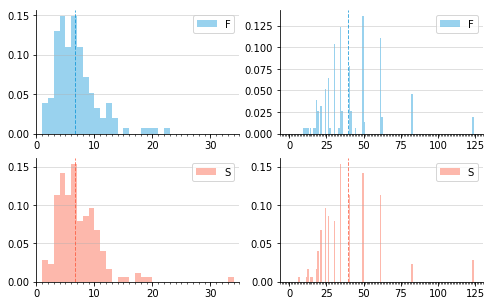

In [28]:
path = 'pipeline_data/s3/joint_data.pkl'
fig = plt.figure(num='hists1', figsize=[8,5])
bins = list(range(40))

save_as = ''

if 1:
    mdata = lut.unpickle(path)['main']
    groups, conds, tasks = lut.get_unique(mdata, [r.ix('group'), r.ix('cond'), r.ix('cat')])

    nonfree = lut.get_mask(mdata, {r.ix('stage'): 1}, '!=')
    mdata[nonfree, r.ix('switch')] = 0
    
    mdata[:-1, r.ix('switch')] = mdata[1:, r.ix('switch')]
    mdata[-1, r.ix('switch')] = 0
    
    freeplay = lut.get_mask(mdata, {r.ix('stage'): 1})
    mdata = mdata[freeplay, :]
    mdata[:, r.ix('trial')] -= 60
    
    switches = {}
    streaks = {}
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    
    
    
    for ax in [ax1, ax2, ax3, ax4]:
        vut.despine(ax, ['top', 'right'])
        ax.grid(True, axis='y', alpha=.5)
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
        
    for grp in groups:
        group_switches = []
        group_streaks = []
        gmask = lut.get_mask(mdata, {r.ix('group'): grp})
        gsids = lut.get_unique(mdata[gmask, :], r.ix('sid'))
        for sid in gsids:
            mask = lut.get_mask(mdata, {r.ix('group'): grp, r.ix('sid'): sid})
            switch_col = mdata[mask, r.ix('switch')]
            streak_lens = np.append(mdata[mask, r.ix('blkt')][switch_col.astype(bool)], mdata[mask, r.ix('blkt')][-1])
            nb_switches = np.sum(switch_col)
            group_switches.append(nb_switches)
            group_streaks.append(np.mean(streak_lens))
        switches[grp] = group_switches
        streaks[grp] = group_streaks
#         vut.line_histogram(ax, np.array(group_switches), bins=bins, label=str(grp), lw=2, c=colors[grp])
        
    for grp, axpair in zip(groups, ([ax1, ax2], [ax3, ax4])):
        data = np.array(switches[grp])
        axpair[0].hist(data, 
                bins=bins, 
                label=glabels[grp],
                density=False, weights=np.zeros_like(data) + 1. / data.size,
                lw=2, 
                color=colors[grp], 
                alpha=.4)
        axpair[0].axvline(np.mean(group_switches), c=colors[grp], alpha=.7, ls='--', lw=1)
        axpair[0].legend()
        axpair[0].set_xlim([0,35])
        
        data = np.array(streaks[grp])
        axpair[1].hist(data,
                bins=np.arange(0,125,1),
                label=glabels[grp],
                density=False, weights=np.zeros_like(data) + 1. / data.size,
                lw=2, 
                color=colors[grp], 
                alpha=.4)
        axpair[1].axvline(np.mean(group_streaks), c=colors[grp], alpha=.7, ls='--', lw=1)
        axpair[1].legend()
    
#     fig.savefig('/Users/alexten/Desktop/hists.svg', format='svg', dpi=500)

## 7.1. How are streak lengths and number of switches related in each individual?

0 | 32.0 [ 15.  22.  32.  67. 109.]
1 | 18.0 [ 0. 12. 12. 15. 16. 20. 23. 32. 37. 74.]
2 | 99.0 [ 32.  99. 117.]
3 | 15.5 [ 1.  5.  5. 11. 12. 13. 15. 16. 20. 21. 22. 30. 44. 46.]
4 | 35.5 [ 3.  3. 21. 35. 36. 42. 46. 57.]
5 | 31.5 [15. 21. 24. 39. 53. 95.]
6 | 55.5 [ 20.  34.  77. 115.]
7 | 48.0 [ 5. 44. 48. 70. 79.]
8 | 16.0 [ 0.  4.  4.  5.  7. 10. 16. 17. 18. 22. 23. 28. 84.]
9 | 31.5 [ 0. 22. 24. 30. 33. 38. 44. 51.]
10 | 17.5 [11. 13. 13. 14. 17. 18. 30. 34. 43. 48.]
11 | 27.5 [14. 20. 20. 35. 74. 88.]
12 | 22.0 [ 1.  1.  8.  9. 19. 19. 22. 23. 23. 26. 33. 34. 37.]
13 | 11.5 [  2.   4.   4.   8.  11.  12.  14.  23.  56. 106.]
14 | 30.0 [ 5.  8. 11. 30. 36. 68. 85.]
15 | 23.0 [13. 13. 19. 23. 41. 49. 86.]
16 | 26.0 [10. 17. 17. 19. 26. 27. 33. 37. 55.]
17 | 31.5 [ 3.  4.  4.  8. 29. 34. 36. 40. 40. 42.]
18 | 37.0 [ 1.  1.  6. 37. 39. 74. 85.]
19 | 20.0 [  1.   7.  19.  20.  20.  55. 121.]
20 | 18.5 [ 3. 15. 16. 16. 17. 17. 20. 22. 22. 23. 23. 45.]
21 | 25.0 [ 7.  8. 20. 25. 48. 49

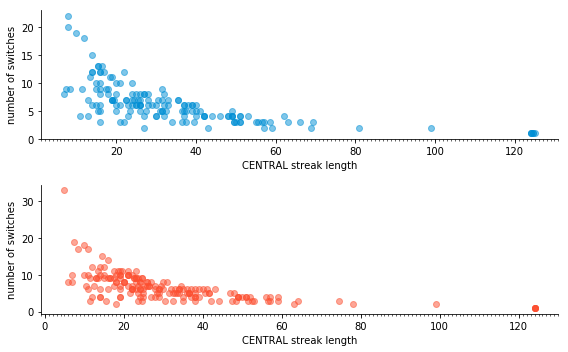

In [29]:
path = 'pipeline_data/s3/joint_data.pkl'
fig = plt.figure(num='hists2', figsize=[8,5])
bins = list(range(40))

save_as = ''

if 1:
    mdata = lut.unpickle(path)['main']
    groups, conds, tasks = lut.get_unique(mdata, [r.ix('group'), r.ix('cond'), r.ix('cat')])

    nonfree = lut.get_mask(mdata, {r.ix('stage'): 1}, '!=')
    mdata[nonfree, r.ix('switch')] = 0
    
    mdata[:-1, r.ix('switch')] = mdata[1:, r.ix('switch')]
    mdata[-1, r.ix('switch')] = 0
    
    freeplay = lut.get_mask(mdata, {r.ix('stage'): 1})
    mdata = mdata[freeplay, :]
    mdata[:, r.ix('trial')] -= 60
    
    switches = {}
    streaks = {}
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    axes = [ax1, ax2]
    
    for ax in axes:
        vut.despine(ax, ['top', 'right'])
        ax.set_xlabel('CENTRAL streak length')
        ax.set_ylabel('number of switches')
#         ax.grid(True, axis='y', alpha=.5)
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
        
    for grp in groups:
        group_switches = []
        group_streaks = []
        gmask = lut.get_mask(mdata, {r.ix('group'): grp})
        gsids = lut.get_unique(mdata[gmask, :], r.ix('sid'))
        for sid in gsids:
            mask = lut.get_mask(mdata, {r.ix('group'): grp, r.ix('sid'): sid})
            switch_col = mdata[mask, r.ix('switch')]
            streak_lens = np.append(mdata[mask, r.ix('blkt')][switch_col.astype(bool)], mdata[mask, r.ix('blkt')][-1])
            nb_switches = np.sum(switch_col)
            group_switches.append(nb_switches)
            group_streaks.append(np.median(streak_lens))
            if not grp:
                print(sid, '|', np.median(streak_lens), np.sort(streak_lens)) 
        switches[grp] = group_switches
        streaks[grp] = group_streaks
        axes[grp].scatter(group_streaks, group_switches, color=colors[grp], alpha=.5)
#         vut.line_histogram(ax, np.array(group_switches), bins=bins, label=str(grp), lw=2, c=colors[grp])
        
#     for grp, axpair in zip(groups, ([ax1, ax2], [ax3, ax4])):
#         data = np.array(switches[grp])
#         axpair[0].hist(data, 
#                 bins=bins, 
#                 label=glabels[grp],
#                 density=False, weights=np.zeros_like(data) + 1. / data.size,
#                 lw=2, 
#                 color=colors[grp], 
#                 alpha=.4)
#         axpair[0].axvline(np.mean(group_switches), c=colors[grp], alpha=.7, ls='--', lw=1)
#         axpair[0].legend()
#         axpair[0].set_xlim([0,35])
        
#         data = np.array(streaks[grp])
#         axpair[1].hist(data,
#                 bins=np.arange(0,125,1),
#                 label=glabels[grp],
#                 density=False, weights=np.zeros_like(data) + 1. / data.size,
#                 lw=2, 
#                 color=colors[grp], 
#                 alpha=.4)
#         axpair[1].axvline(np.mean(group_streaks), c=colors[grp], alpha=.7, ls='--', lw=1)
#         axpair[1].legend()
        fig.tight_layout()
#     fig.savefig('/Users/alexten/Desktop/hists.svg', format='svg', dpi=500)

In [26]:
smask = lut.get_mask(mdata, {r.ix('sid'): 75, r.ix('stage'):1})
lut.print_arr(mdata[smask, :-1], r.cols[:-1], )

     GROUP  SID  TRIAL  COND  STAGE  BLKT  FAM  D1  D2  CAT  FOOD  COR  SWITCH
0        0   75      1     1      1     0    2   2   3    2     1    1       0
1        0   75      2     1      1     1    2   1   4    2     1    1       0
2        0   75      3     1      1     2    2   5   4    2     1    0       0
3        0   75      4     1      1     3    2   1   6    2     5    0       0
4        0   75      5     1      1     4    2   5   6    2     5    1       0
5        0   75      6     1      1     5    2   2   4    2     5    0       0
6        0   75      7     1      1     6    2   4   2    2     5    1       0
7        0   75      8     1      1     7    2   2   4    2     5    0       0
8        0   75      9     1      1     8    2   2   1    2     1    1       0
9        0   75     10     1      1     9    2   1   5    2     1    1       0
10       0   75     11     1      1    10    2   3   3    2     1    1       0
11       0   75     12     1      1    11    2   1  